<a href="https://colab.research.google.com/github/6mupila/thesis-work-/blob/main/Forensic_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

# Load the dataset
df = pd.read_csv('large_forensic_logs_dataset.csv')

# Rename the 'Label (tampered log)' column for simplicity
df.rename(columns={'Label (tampered log)': 'tampered_log'}, inplace=True)

# Verify the column names
print(df.columns)

# Basic data exploration
print(df.head())
print(df.info())
print(df.describe())

Index(['DataType', 'Timestamp', 'UserID', 'AccessLocation', 'EventSeverity',
       'AttackScenario', 'EncryptionStatus', 'AuthMethod', 'GDPR',
       'Indian_IT_Act', 'US_CLOUD_Act', 'Label'],
      dtype='object')
           DataType             Timestamp     UserID AccessLocation  \
0      Forensic Log  2025-07-20T13:41:42Z  user_5314    City_23, CN   
1  Cloud Access Log  2025-03-08T14:12:51Z  user_3845   City_422, ZA   
2      Forensic Log  2025-03-23T14:13:28Z  user_5898   City_264, CN   
3  Cloud Access Log  2025-01-25T14:24:54Z  user_3723   City_136, US   
4  Cloud Access Log  2025-02-13T03:44:48Z  user_5930   City_161, IN   

  EventSeverity       AttackScenario EncryptionStatus   AuthMethod GDPR  \
0          High       Insider Threat        Encrypted          NaN   No   
1          High                  NaN    Not Encrypted          MFA   No   
2        Medium             Phishing    Not Encrypted  Private Key   No   
3        Medium  Unauthorized Access    Not Encrypted  Pr

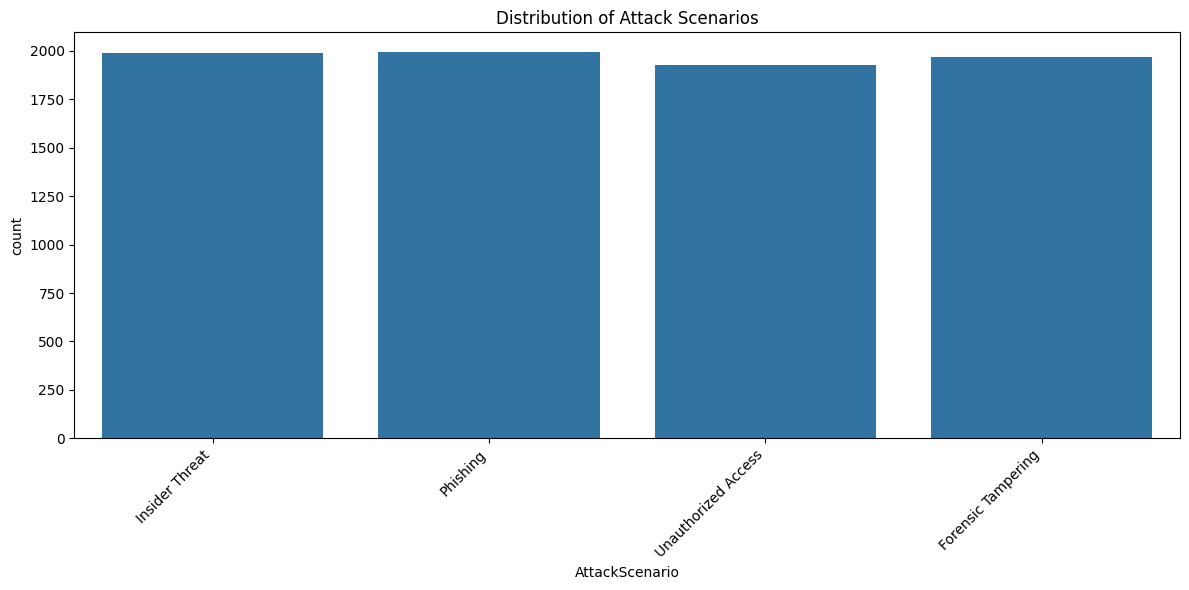

In [2]:
plt.figure(figsize=(12, 6))
sns.countplot(x='AttackScenario', data=df)
plt.title('Distribution of Attack Scenarios')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

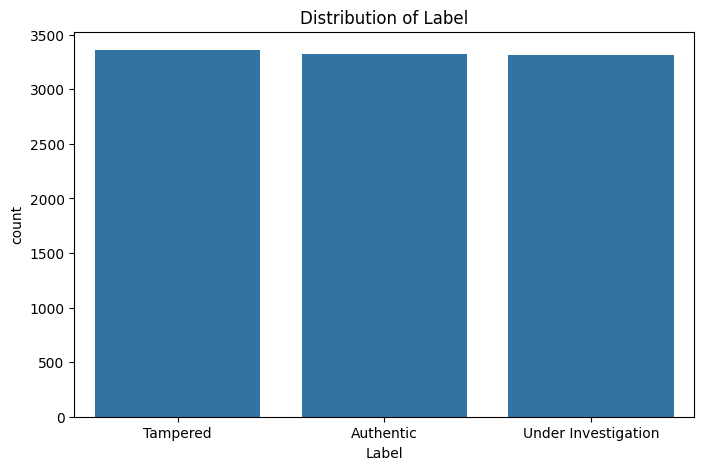

In [3]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Label', data=df)
plt.title('Distribution of Label')
plt.show()

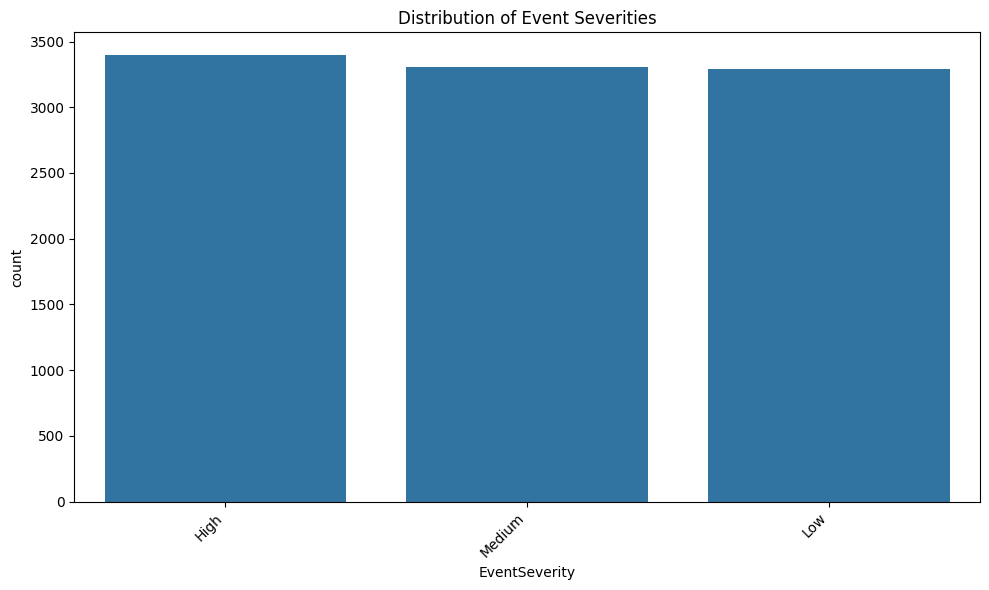

In [4]:
if 'EventSeverity' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(x='EventSeverity', data=df, order=df['EventSeverity'].value_counts().index)
    plt.title('Distribution of Event Severities')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("EventSeverity column not found.")

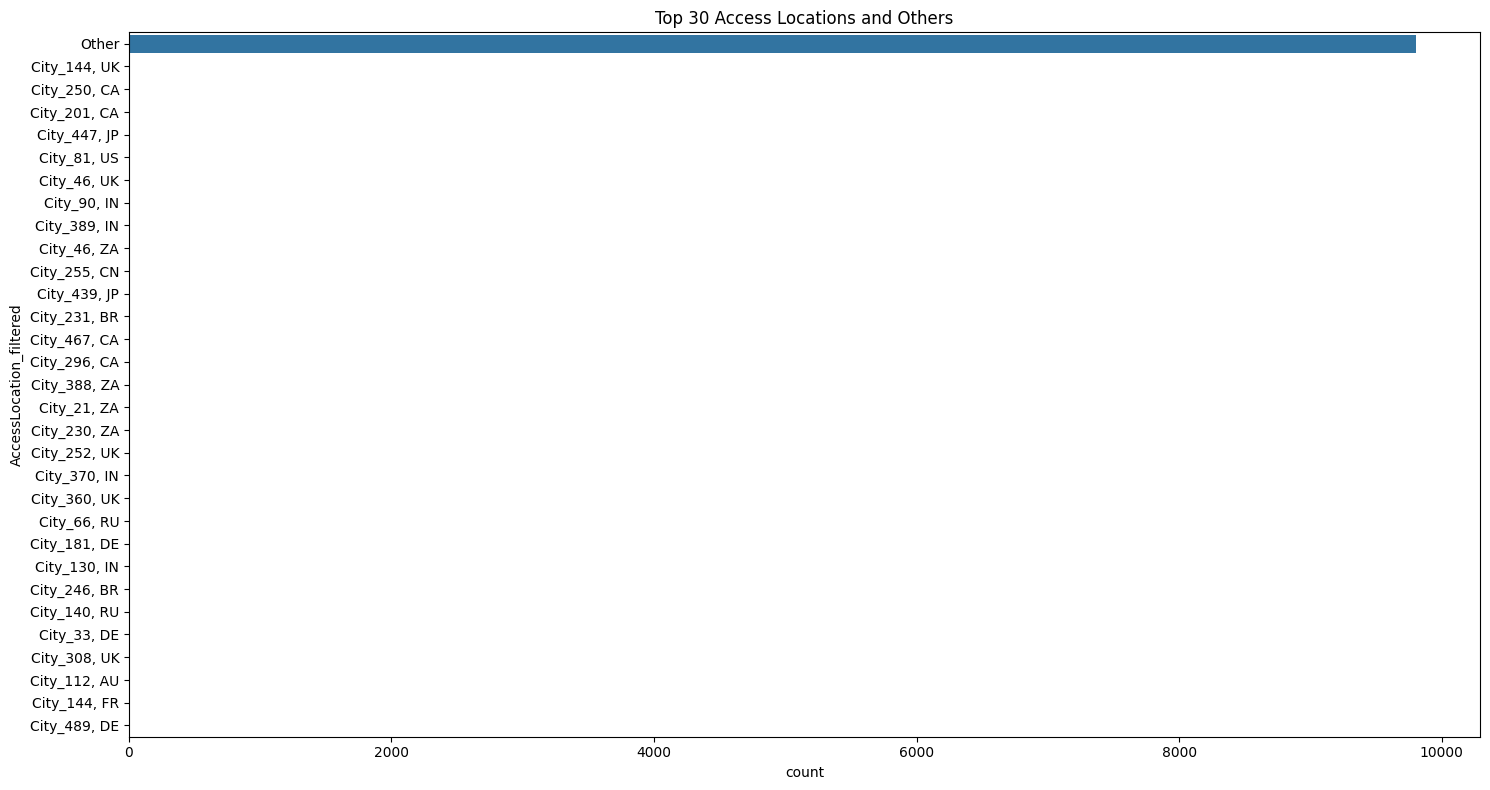

In [5]:
if 'AccessLocation' in df.columns:
    top_n = 30
    min_frequency = 2

    location_counts = df['AccessLocation'].value_counts()
    top_locations = location_counts.head(top_n).index.tolist()

    df['AccessLocation_filtered'] = df['AccessLocation'].apply(lambda x: x if x in top_locations else 'Other')

    plt.figure(figsize=(15, 8))
    sns.countplot(y='AccessLocation_filtered', data=df, order=df['AccessLocation_filtered'].value_counts().index)
    plt.title(f'Top {top_n} Access Locations and Others')
    plt.tight_layout()
    plt.show()

    df.drop('AccessLocation_filtered', axis=1, inplace=True)
else:
    print("AccessLocation column not found.")

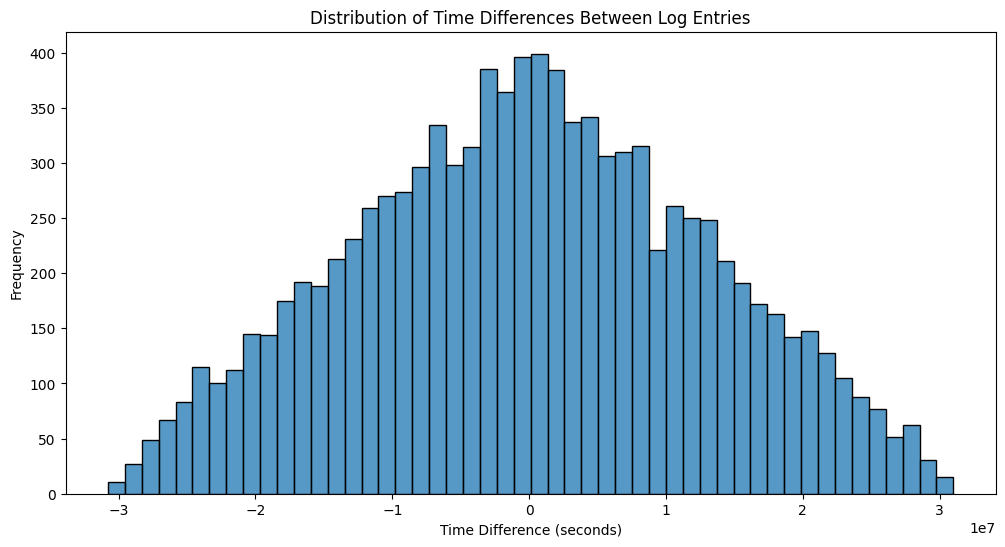

Number of large time gaps (over 1 hour): 4995
Out-of-order timestamps detected.


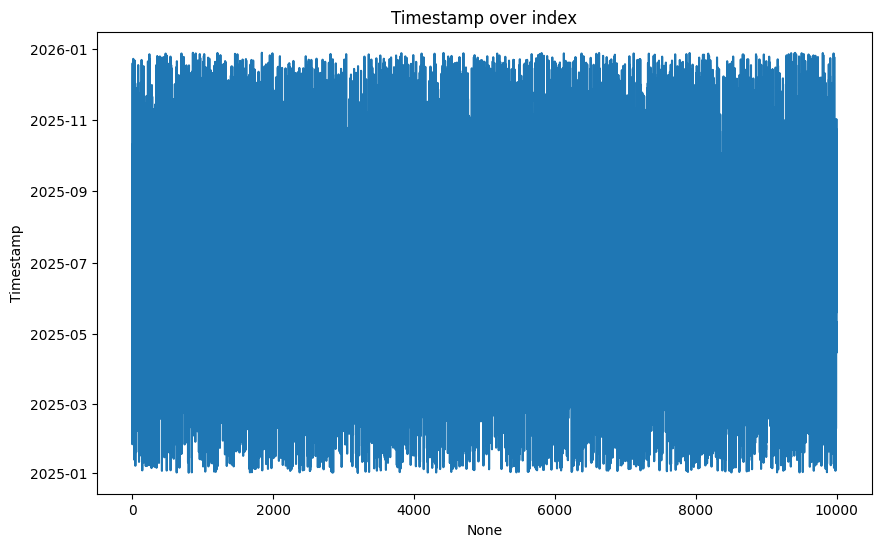

In [6]:
if 'Timestamp' in df.columns:
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['time_diff'] = df['Timestamp'].diff().dt.total_seconds()

    plt.figure(figsize=(12, 6))
    sns.histplot(df['time_diff'].dropna(), bins=50)
    plt.title('Distribution of Time Differences Between Log Entries')
    plt.xlabel('Time Difference (seconds)')
    plt.ylabel('Frequency')
    plt.show()

    large_gaps = df[df['time_diff'] > 3600]
    print(f"Number of large time gaps (over 1 hour): {len(large_gaps)}")

    df['time_diff_sign'] = df['time_diff'].apply(lambda x: 1 if x >= 0 else -1)
    if (df['time_diff_sign'] == -1).any():
        print("Out-of-order timestamps detected.")
    else:
        print("Timestamps appear to be in chronological order.")

    plt.figure(figsize=(10,6))
    sns.lineplot(x = df.index, y = 'Timestamp', data = df)
    plt.title("Timestamp over index")
    plt.show()

else:
    print("Timestamp column not found.")

In [7]:

# %%
try:
    if 'EncryptionStatus' in df.columns and 'Label' in df.columns:
        # Convert 'Label' to numerical data using .astype('category').cat.codes
        df['Label_numerical'] = df['Label'].astype('category').cat.codes
        # Now calculate the correlation between the numerical representations
        correlation = df['EncryptionStatus'].astype('category').cat.codes.corr(df['Label_numerical'])
        print(f"Correlation between Encryption Status and Label: {correlation}")
        df.drop("Label_numerical", axis=1, inplace=True)
except Exception as e:
    print(f"Failed to calculate correlation between EncryptionStatus and Label: {e}")

Correlation between Encryption Status and Label: -0.003130132021551309


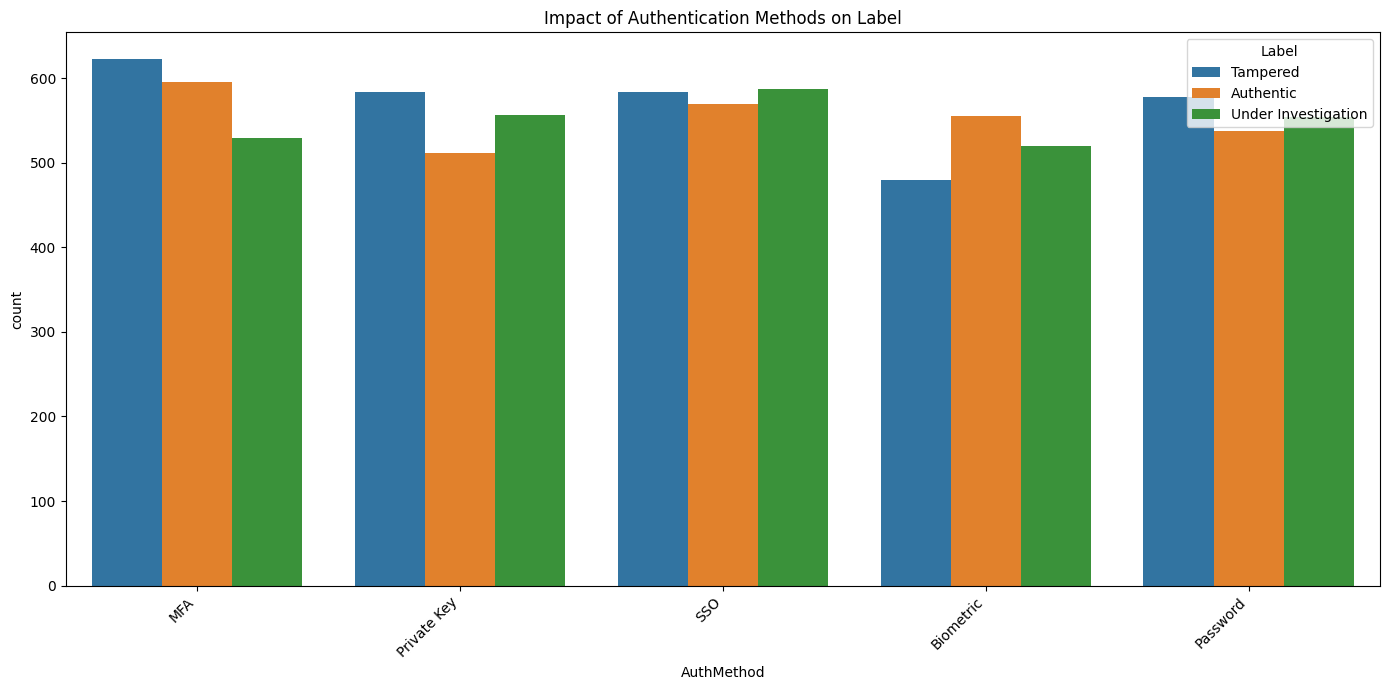

In [8]:
if 'AuthMethod' in df.columns and 'Label' in df.columns:
    plt.figure(figsize=(14, 7))
    sns.countplot(x='AuthMethod', hue='Label', data=df)
    plt.title('Impact of Authentication Methods on Label')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("Authentication method or Label column not found.")

In [9]:
# Inspect the unique values in the columns to ensure they only contain 'yes' or 'no'
cols_to_convert = ['GDPR', 'Indian_IT_Act', 'US_CLOUD_Act']
for col in cols_to_convert:
    if col in df.columns:
        print(f"Unique values in {col}: {df[col].unique()}")

# Convert the columns to int64 to avoid division errors with strings
# Make sure we have access to all the relevant columns before attempting to convert them
cols_to_convert = ['GDPR', 'Indian_IT_Act', 'US_CLOUD_Act']
for col in cols_to_convert:
    if col in df.columns:
        # Create a mapping for 'Yes' to 1 and 'No' to 0, otherwise to 0 to handle any other values
        mapping = {'Yes': 1, 'No': 0}
        # If there are any values other than 'yes' or 'no', then print a message and map all non 'yes' to 0
        if set(df[col].unique()) - set(mapping.keys()):
          print(f"Warning: Column {col} has values other than 'Yes' or 'No'. They will be mapped to 0")
          df[col] = df[col].replace({k: v for k, v in mapping.items()}).fillna(0).astype('int64')
        else:
          df[col] = df[col].replace(mapping).fillna(0).astype('int64')

# %%
# Compliance Rate Analysis
print(f"GDPR Compliance Rate: {df['GDPR'].sum() / len(df) * 100:.2f}%")
print(f"Indian IT Act Compliance Rate: {df['Indian_IT_Act'].sum() / len(df) * 100:.2f}%")
print(f"US CLOUD Act Compliance Rate: {df['US_CLOUD_Act'].sum() / len(df) * 100:.2f}%")

# Correlation with EventSeverity and tampered logs
if 'EventSeverity' in df.columns:
    print(f"Correlation GDPR and EventSeverity: {df['GDPR'].corr(df['EventSeverity'].astype('category').cat.codes)}")
    print(f"Correlation Indian IT Act and EventSeverity: {df['Indian_IT_Act'].corr(df['EventSeverity'].astype('category').cat.codes)}")
    print(f"Correlation US CLOUD Act and EventSeverity: {df['US_CLOUD_Act'].corr(df['EventSeverity'].astype('category').cat.codes)}")

if 'tampered_log' in df.columns:
    print(f"Correlation GDPR and tampered_log: {df['GDPR'].corr(df['tampered_log'])}")
    print(f"Correlation Indian IT Act and tampered_log: {df['Indian_IT_Act'].corr(df['tampered_log'])}")
    print(f"Correlation US CLOUD Act and tampered_log: {df['US_CLOUD_Act'].corr(df['tampered_log'])}")

Unique values in GDPR: ['No' 'Yes']
Unique values in Indian_IT_Act: ['No' 'Yes']
Unique values in US_CLOUD_Act: ['No' 'Yes']
GDPR Compliance Rate: 49.65%
Indian IT Act Compliance Rate: 49.57%
US CLOUD Act Compliance Rate: 50.25%
Correlation GDPR and EventSeverity: 0.0012637840742521643
Correlation Indian IT Act and EventSeverity: -0.004616038406579496
Correlation US CLOUD Act and EventSeverity: -0.003728783806857918


<ipython-input-9-42c6fb46dacf>:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(mapping).fillna(0).astype('int64')
<ipython-input-9-42c6fb46dacf>:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(mapping).fillna(0).astype('int64')
<ipython-input-9-42c6fb46dacf>:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior,

In [10]:
# Install required packages
!pip install pandas scikit-learn matplotlib seaborn

In [11]:
# Prepare data
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

if 'Label' in df.columns:
    X = df.drop('Label', axis=1)
    y = df['Label']

    # Store name of columns before one-hot encoding
    cols = X.columns

    # Drop the Timestamp column before one-hot encoding
    if 'Timestamp' in X.columns:
      X = X.drop('Timestamp', axis=1) #Drop Timestamp because it will not be useful in training our model

    # One-hot encode categorical variables and fill missing values
    X = pd.get_dummies(X)
    X = X.fillna(0)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train model
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    # Evaluate model
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

    # Feature importance
    feature_importance = pd.Series(model.feature_importances_, index=X.columns)
    print(feature_importance.nlargest(10))
else:
    print("Label")

                     precision    recall  f1-score   support

          Authentic       0.32      0.27      0.29       684
           Tampered       0.34      0.40      0.37       663
Under Investigation       0.31      0.31      0.31       653

           accuracy                           0.33      2000
          macro avg       0.32      0.33      0.32      2000
       weighted avg       0.32      0.33      0.32      2000

Accuracy: 0.325
time_diff                             0.053935
GDPR                                  0.012553
US_CLOUD_Act                          0.012274
Indian_IT_Act                         0.011936
AttackScenario_Phishing               0.008243
EncryptionStatus_Encrypted            0.008037
EncryptionStatus_Not Encrypted        0.008013
AttackScenario_Unauthorized Access    0.007958
AttackScenario_Insider Threat         0.007935
AttackScenario_Forensic Tampering     0.007848
dtype: float64


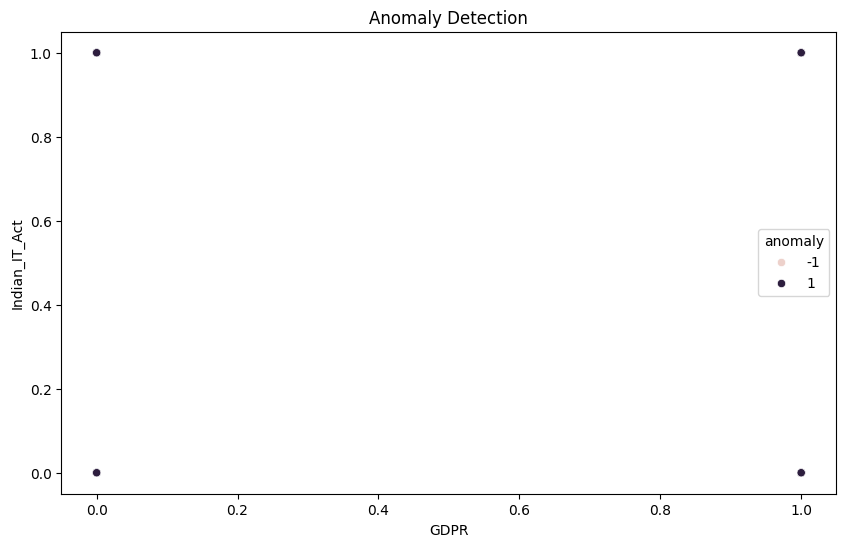

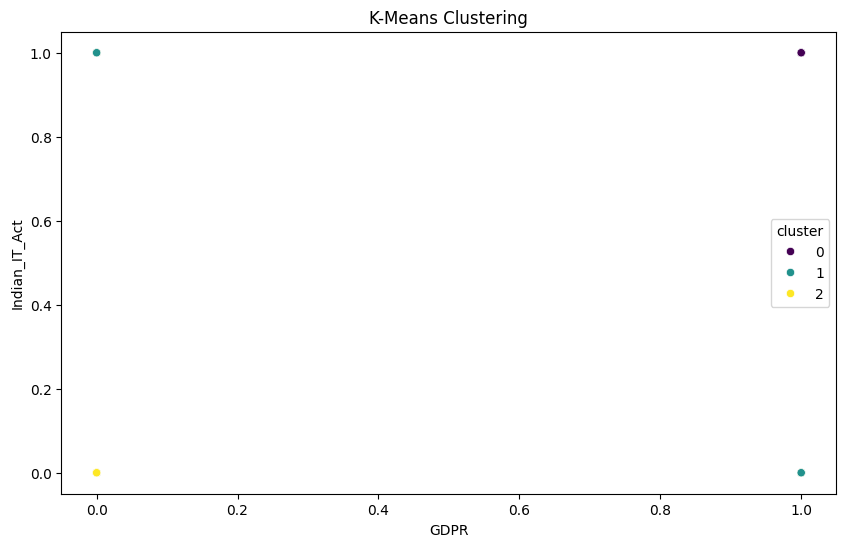

In [12]:
# Prepare numerical features
numerical_features = df.select_dtypes(include=np.number)
numerical_features = numerical_features.fillna(0)

# Isolation Forest
anomaly_detector = IsolationForest(contamination=0.05)
anomaly_detector.fit(numerical_features)
anomalies = anomaly_detector.predict(numerical_features)
df['anomaly'] = anomalies

# Visualize anomalies
if numerical_features.shape[1] >= 2:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=numerical_features.iloc[:, 0], y=numerical_features.iloc[:, 1], hue=df['anomaly'])
    plt.title('Anomaly Detection')
    plt.show()
else:
    print("Not enough numerical columns to visualize anomalies.")

# K-Means Clustering
scaler = StandardScaler()
scaled_features = scaler.fit_transform(numerical_features)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_features)
df['cluster'] = clusters;

if numerical_features.shape[1] >= 2:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=numerical_features.iloc[:, 0], y=numerical_features.iloc[:, 1], hue=df['cluster'], palette='viridis')
    plt.title('K-Means Clustering')
    plt.show()
else:
    print("Not enough numerical columns to visualize clusters.")